In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/StableManipulation/Project.toml`


In [2]:
using LinearAlgebra
using ForwardDiff
using OrdinaryDiffEq
using Plots
using Convex, SCS
using JLD
using StableManipulation

In [3]:
# (1) system properties and contact

const g = 9.81

const m = 1
const μ = 0.5 # pusher-slider friction coefficient

const w = 1.0 # width of the slider (x axis)
const h = 1.0 # height of the slider (y aixs)

const M = [m 0 0; 0 m 0; 0 0 m*((h/2)^2+(w/2)^2)/3] # inertia matrix

const A_ls = [1 0 0; 0 1 0; 0 0 1.5] # ellipsoid limit surface

const modes = [0 0; # free
            1 0; # sticking
            1 1; # right slide 
            1 -1] # left slide

const n_contacts = 1 

# simulation step size
const Δt = 0.05
# tolerance for contacts
const tol_c = 1e-5

# q = [x_s, y_s, θ_s, x_p, y_p]
# x_s, y_s, θ_s: object world coordinate
# x_p, y_p: pusher location in the object frame


1.0e-5

In [4]:
include("../models/model_utils.jl")

rk4_step (generic function with 1 method)

In [5]:
# only consider the block is pushed on the edge of x = -w/2 
function compute_a(q)

    d = -(q[4] - (-w/2))
    if (abs(d) < 1e-7)
        d = 0.0
    end
    return d
end

compute_a (generic function with 1 method)

In [6]:
function compute_A(q)
    A = ForwardDiff.gradient(compute_a, q)
    return A
end

compute_A (generic function with 1 method)

In [7]:
function motion_cone(vp, p)
    # vp: pusher velocity in the body frame
    # p: pusher location in the body frame (assume pusher make contact with x = -w/2 edge)

    # return (pusher motion relative to the slider)
    # 0 sticking, 1 right slide, -1 left slide

    Jp = [1 0 -p[2]; 0 1 p[1]]

    fl = [1; -μ]
    fr = [1; μ]

    Fl = Jp'*fl
    Fr = Jp'*fr

    Vl = A_ls*Fl
    Vr = A_ls*Fr

    vl = Jp*Vl # vl[1] > 0, vl[2] < 0, slider sliding to the left of the pusher
    vr = Jp*Vr # vr[1] > 0, vr[2] > 0, slider sliding to the right of the pusher 

    if vp[2]/vp[1] > vr[2]/vr[1]
        return 1
    elseif vp[2]/vp[1] < vl[2]/vl[1]
        return -1
    end
    
    return 0
end

motion_cone (generic function with 1 method)

In [8]:
# quasi-static: x = q
function solveEOM(x, u_control)
    # u_control: velocity of the pusher in the world frame
    R_WO = R_2D(x[3])

    if (abs(compute_a(x)) > tol_c)
        return [0;0;0;R_WO'*u_control]
    end

   
    vp = R_WO'*u_control
    p = x[4:5]

    if (vp[1] < 0) || (abs(p[2]) > h/2)
        # leaving
        return [0;0;0;u_control]
    end
    
    mc = motion_cone(vp, p)

    Jp = [1 0 -p[2]; 0 1 p[1]]

    fl = [1; -μ]
    fr = [1; μ]

    Fl = Jp'*fl
    Fr = Jp'*fr

    if mc == 0
        # println("stick")
        t = [-p[2];p[1];-1]
        D = [Jp' inv(A_ls)*t]'
        Vp = [vp;0]
        V = inv(D)*Vp
        v = [0;0]
    else
        if mc == 1
            # println("right slide")
            V = A_ls*Fr
        else
            # println("left slide")
            V = A_ls*Fl
        end
        k = vp[1]/(V[1] - V[3]*p[2])
        V = k*V
        v = vp - Jp*V
    end

    V_w = [R_WO [0;0];0 0 1]*V

    return [V_w; v]
end

solveEOM (generic function with 1 method)

In [9]:
function continuous_dynamics_differentiable(x, u, mode)
    # u_control: velocity of the pusher in the world frame
    R_WO = R_2D(x[3])
    if mode[1] == 0
        return [0;0;0;R_WO'*u]
    end

    R_WO = R_2D(x[3])
    vp = R_WO'*u
    p = x[4:5]

    Jp = [1 0 -p[2]; 0 1 p[1]]

    fl = [1; -μ]
    fr = [1; μ]

    Fl = Jp'*fl
    Fr = Jp'*fr

    if mode[2] == 0
        # println("stick")
        t = [-p[2];p[1];-1]
        D = [Jp' inv(A_ls)*t]'
        Vp = [vp;0]
        V = inv(D)*Vp
        v = [0;0]
    else
        if mode[2] == 1
            # println("right slide")
            V = A_ls*Fr
        else
            # println("left slide")
            V = A_ls*Fl
        end
        k = vp[1]/(V[1] - V[3]*p[2])
        V = k*V
        v = vp - Jp*V
    end

    V_w = [R_WO [0;0];0 0 1]*V

    return [V_w; v]
end

continuous_dynamics_differentiable (generic function with 1 method)

In [10]:
function discrete_dynamics(x, u, mode)
    xn = rk4_step((_x,_u)->continuous_dynamics_differentiable(_x,_u,mode),x,u)
    return xn
end

discrete_dynamics (generic function with 1 method)

In [11]:
function ode_dynamics!(dx, x, p, t)
    # p from integrator: (contact mode, controller, t_control, h_control, u_control)
    

    contactMode = p[1]
    controller = p[2]
    t_control = p[3][1]
    h_control = p[4]
    u_control = zeros(2)
    u_control .= p[5]
    
    if t > (t_control + h_control)
        p[3] .= [Float64(t)]
        u_control = controller(x, t)
        p[5] .= u_control
    end
    

    dx .= solveEOM(x, u_control)

end

ode_dynamics! (generic function with 1 method)

In [12]:
function ode_conditions(out, x, t, integrator)
    c = compute_a(x)
    out .= c
end

ode_conditions (generic function with 1 method)

In [13]:
function ode_affect_neg!(integrator, idx)
    # if debug == true
    #     println("down crossing.")
    # end
    # u_control = controller(x)
    # integrator.p[5] .= u_control
end

ode_affect_neg! (generic function with 1 method)

In [14]:
function push_controller(x,t)
    return [0.5;0]
end

push_controller (generic function with 1 method)

In [87]:
# straight line pushing 
pusher_u_ref = [0.0;0.0]
nominal_mode = [1,0]
xref = [0,0,0,-w/2,0]

5-element Vector{Float64}:
  0.0
  0.0
  0.0
 -0.5
  0.0

In [88]:
# LQR controller
A_lqr = ForwardDiff.jacobian(_x->discrete_dynamics(_x, pusher_u_ref, nominal_mode), xref)
B_lqr = ForwardDiff.jacobian(_u->discrete_dynamics(xref, _u, nominal_mode), pusher_u_ref)
Q_lqr = Diagonal([1.0;1.0;1.0;2.0;2.0])
R_lqr = Diagonal([0.1;0.1])
Ks, _ = StableManipulation.riccati(A_lqr,B_lqr,Q_lqr,R_lqr,Q_lqr,50)
K_lqr = Ks[1]

2×5 Matrix{Float64}:
 2.92214  0.0       0.0      0.0  0.0
 0.0      2.35453  -1.76589  0.0  0.0

In [44]:
l_traj = 2.0
h_traj = 0.1
t_traj = 10.0
n_traj = ceil(Int,l_traj/h_traj)
xrefs = zeros(n_traj, 5)
for k = 1:n_traj
    xrefs[k,:] .= [k*l_traj/n_traj,0,0,-w/2,0]
end

In [46]:
function time2step(t)
    return min(ceil(Int,(t+1e-5)*n_traj/t_traj), n_traj)
end

time2step (generic function with 1 method)

In [89]:
function lqr_controller(x,t)
    idx = time2step(t)
    xref_k = xrefs[idx,:]
    u = pusher_u_ref .- K_lqr*(x.-xref_k)
    return u
end

lqr_controller (generic function with 1 method)

## Hybrid controller

In [21]:
# Lyapunov function
function V(x, x_ref)
    v = 0.5*(x.-x_ref)'*Q_lqr*(x.-x_ref)
    return v
end

function dVdx(x, x_ref)
    return Q_lqr*(x.-x_ref)
end

dVdx (generic function with 1 method)

In [22]:
function domain(x, u, contactMode)
    d = compute_a(x)

    R_WO = R_2D(x[3])
    vp = R_WO'*u

    p = x[4:5]

    Jp = [1 0 -p[2]; 0 1 p[1]]

    fl = [1; -μ]
    fr = [1; μ]

    Fl = Jp'*fl
    Fr = Jp'*fr

    Vl = A_ls*Fl
    Vr = A_ls*Fr

    vl = Jp*Vl # vl[1] > 0, vl[2] < 0, slider sliding to the left of the pusher
    vr = Jp*Vr # vr[1] > 0, vr[2] > 0, slider sliding to the right of the pusher 

    if contactMode[1] == 0
        # separating/free contact
        # vp[1] < 0
        # d >= 0
        ineqs = [-vp[1];d-1e-5]
        eqs = zeros(0)    
    else
        if contactMode[2] == 0
            # vp[2]/vp[1] < vr[2]/vr[1]
            # vp[2]/vp[1] > vl[2]/vl[1]
            if abs(vp[1]) < 1e-6
                ineqs = [ - vp[2]; vp[2]; vp[1]]
            else
                ineqs = [vr[2]/vr[1] - vp[2]/vp[1]; vp[2]/vp[1] - vl[2]/vl[1]; vp[1]]
            end
            eqs = [d]
        else 
            if contactMode[2] == -1
                # vp[2]/vp[1] < vl[2]/vl[1]
                if abs(vp[1]) < 1e-6
                    ineqs = [-vp[2]; vp[1]]
                else
                    ineqs = [vl[2]/vl[1] - vp[2]/vp[1]; vp[1]]
                end
                eqs = [d]
            else
                # vp[2]/vp[1] > vr[2]/vr[1]
                if abs(vp[1]) < 1e-6
                    ineqs = [vp[2]; vp[1]]
                else
                    ineqs = [vp[2]/vp[1] - vr[2]/vr[1]; vp[1]]
                end
                eqs = [d]
            end
        end
    end
    
    return ineqs, eqs
end  

domain (generic function with 1 method)

In [23]:
const n_modes = size(modes, 1)

const n_u = 2
const n_β = 15
const n_α = n_modes

4

In [24]:
fuz = 0.0

function hybrid_constraints_matrix(x, u_ref, x_ref)
    n = n_u + n_β + n_α
    m = n_modes

    A = zeros(m, n)
    b = zeros(m)

    nominal_mode = [1,0] # sticking pusher-slider contact

    β_idx = 1

    Vx = dVdx(x, x_ref)
    Vv = V(x, x_ref)

    # println("dVdx: ", Vx)
    # println("V ", Vv)

    for k = 1:n_modes 
        mode = modes[k,:]
        d_ineq, d_eq = domain(x, u_ref, mode)

        n_ineq = size(d_ineq, 1)
        n_eq = size(d_eq, 1)

        if (mode[1] == 0)
            β_idx += n_ineq + 2*n_eq
            continue
        end

        dfdu = ForwardDiff.jacobian(_u->continuous_dynamics_differentiable(x, _u, mode), u_ref)
        # println("dfdu ", dfdu)

        b[k] = -Vx'*continuous_dynamics_differentiable(x, u_ref, mode)

        # println("-Vx*f ", b[k])

        A[k, n_u+n_β+k] = -Vv
        A[k, 1:n_u] = -Vx'*dfdu
        A[k, β_idx:β_idx+n_ineq-1] .= -(d_ineq .+ fuz)
        A[k, β_idx+n_ineq:β_idx+n_ineq+n_eq-1] .= -(d_eq .+ fuz)
        A[k, β_idx+n_ineq+n_eq:β_idx+n_ineq+2*n_eq-1] .= d_eq .- fuz

        β_idx += n_ineq + 2*n_eq
        
    end

    return A, b

end


hybrid_constraints_matrix (generic function with 1 method)

In [102]:
function hybrid_controller(x, t)
    
    idx = time2step(t)
    xref_k = xrefs[idx,:]

    u_ref = [0.0,0.0]

    α_ref = 2.0

    n_var = n_u + n_β + n_α

    u = zeros(2)

    u .= u_ref

    stop_thr = 1e-3

    du = [1,1]

    iter = 0

    while any(abs.(du) .> 1e-2) && (iter < 100)

        iter = iter + 1

        z = Variable(n_var)
        
        A, b = hybrid_constraints_matrix(x, u, xref_k)

        problem = minimize(sumsquares(z - [zeros(n_u + n_β); α_ref*ones(n_α)]))
        problem.constraints += A*z + b >= 0
        problem.constraints += z[n_u+1:end] >= 0
        problem.constraints += z[1:n_u] > -0.1
        problem.constraints += z[1:n_u] < 0.1
        problem.constraints += z[1] + u[1] >= 0
        problem.constraints += z[2] + u[2] > -5
        problem.constraints += z[1:n_u] + u < 5

        Convex.solve!(problem, () -> SCS.Optimizer(verbose=false))
        
        z_sol = evaluate(z)

        if any(isnan.(z_sol)) || sum(z_sol) == Inf # infeasible
            # z_sol = zeros(n_var)
            # println("Infeasible: ", x, " t ", t)
            # u .= [0.0,0.0]
            break
        end
    
        du = z_sol[1:n_u]
        

        u .= u .+ du

        # println("iter ", iter, ": du = ", du, ", u = ", u)
    end

    println("u, ", u)

    return u
end

hybrid_controller (generic function with 1 method)

In [99]:
function hybrid_controller_no_iter(x, t)
    
    idx = time2step(t)
    xref_k = xrefs[idx,:]

    # u_ref = [0.5,0]
    u_ref = [0.0,0.0]

    α_ref = 2.0

    n_var = n_u + n_β + n_α

    u = u_ref

    stop_thr = 1e-3

    du = [1,1]

    iter = 0

    while any(abs.(du) .> 1e-2) && (iter < 1)

        iter = iter + 1

        z = Variable(n_var)
        
        A, b = hybrid_constraints_matrix(x, u, xref_k)

        problem = minimize(sumsquares(z - [zeros(n_u + n_β); α_ref*ones(n_α)]))
        problem.constraints += A*z + b >= 0
        problem.constraints += z[n_u+1:end] >= 0
        problem.constraints += z[1:n_u] > -0.5
        problem.constraints += z[1:n_u] < 0.5
        # problem.constraints += z[1:n_u] <= 10
        # problem.constraints += z[1:n_u] >= -10

        Convex.solve!(problem, () -> SCS.Optimizer(verbose=false))
        
        z_sol = evaluate(z)

        if any(isnan.(z_sol)) || sum(z_sol) == Inf # infeasible
            # z_sol = zeros(n_var)
            println("Infeasible: ", x, " t ", t)
            u .= [0.0,0.0]
            break
        end
    
        du = z_sol[1:n_u]
        
        # println("iter ", iter, ": du = ", du)

        u .= u .+ du
    end

    println("u, ", u)

    return u
end

hybrid_controller_no_iter (generic function with 1 method)

In [103]:
controller = hybrid_controller
h_control = Δt

tspan = (0.0, 10.0)

x0 = [0;0;0;-w/2-0.10;0.2]

prob = ODEProblem(ode_dynamics!, x0, tspan, ([0], controller, [0.0], h_control/2, controller(x0,0)))
cb = VectorContinuousCallback(ode_conditions, nothing, ode_affect_neg!, 1)

sol = solve(prob, Tsit5(); callback = cb, abstol=1e-10,reltol=1e-10, adaptive=false,dt=Δt/10)

println("Simulation status: ", sol.retcode)

u, [-1.7478965861302143e-8, -0.20005955711755743]
u, 

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


[0.09911526825538378, -0.3062122898843956]
u, [-8.78032064103284e-9, -0.20003535267531755]
u, [0.09961247666764425, -0.294796009662185]
u, [2.424306454850944e-5, -0.20002158648738858]
u, [0.09974515575124851, -0.2843694097748253]
u, 

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


[0.0905974510136398, -0.2753822316867871]
u, [0.00034690970019189064, -0.24031198883823401]
u, [0.010720264895584884, -0.240225149983865]
u, [0.020589404750665546, -0.24040284787336236]
u, [0.030833882790394108, -0.2404243921331043]
u, [0.041821284692170335, -0.2400015748705304]
u, [0.05281026927395766, -0.2392928137431864]
u, [0.06477903229002849, -0.23799120665085088]
u, [0.07572356802076459, -0.23617178534954208]
u, [0.08626011930813206, -0.23378265735668047]
u, [0.09663077910803126, -0.23019346789721368]
u, [0.1059285967962859, -0.2258080097311596]
u, [0.11419312076549985, -0.21994149578401104]
u, [0.11735470349405752, -0.21334351820075664]
u, [0.2948641924747278, -0.23728122454241507]
u, [0.2707952273019606, -0.22349030936685474]
u, [0.25708878952666386, -0.21413066385771376]
u, [0.23823927178377122, -0.20588437828220463]
u, [0.2310998373438343, -0.19724570386793908]
u, [0.22078209006672173, -0.1871814070634487]
u, [0.21800138692948046, -0.1788142659496853]
u, [0.20969799385626584

In [93]:
function boxshape(q)
    p1 = q[1:2] + R_2D(q[3])*[w/2;h/2]
    p2 = q[1:2] + R_2D(q[3])*[w/2;-h/2]
    p3 = q[1:2] + R_2D(q[3])*[-w/2;-h/2]
    p4 = q[1:2] + R_2D(q[3])*[-w/2;h/2]
    pp = [p1 p2 p3 p4]
    return Shape(pp[1,:], pp[2,:])
end

function animation(x, n; interval_n = 1, fps = 30)
    anim = Plots.Animation()
    for k = [1:Int(floor(n/interval_n)+1); -1]
        i = (k-1)*interval_n+1
        if k == -1
            i = n
        end
        p = plot(boxshape([x[i][1],x[i][2],x[i][3]]), aspect_ratio=:equal, c=:gray, opacity=.7, legend=false)
        xp = R_2D(x[i][3])*x[i][4:5] + x[i][1:2]
        scatter!(p,[xp[1]],[xp[2]], markersize=5, xlims=(-2,10), ylims=(-2,2))
        frame(anim, p)
    end
    
    Plots.gif(anim, "anim.gif", fps = fps)
end


animation (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/xianyi/.julia/dev/StableManipulation/example/anim.gif
└ @ Plots /home/xianyi/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/xianyi/.julia/dev/StableManipulation/example/anim.gif")
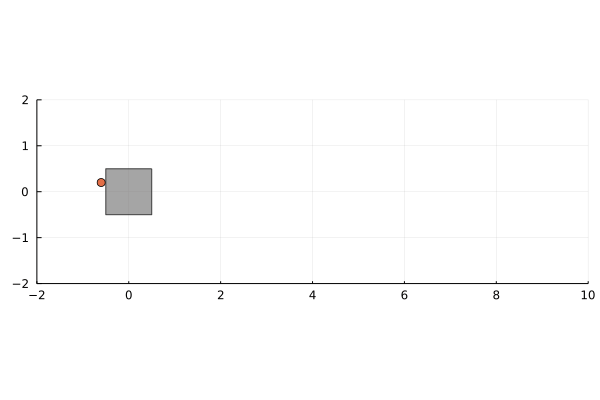

In [104]:
animation(sol.u,length(sol.t)-1, interval_n = 10)
# animation(sol.u,250, interval_n = 1)